In [1]:
import glob

import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
filename = "ENMAP01-____L2A-DT0000004850_20221026T112131Z_005_V010201_20230421T172449Z-SPECTRAL_IMAGE.TIF"
filepath = glob.glob("data/**/"+filename)[0]
metaname = "-".join(filename.split("-")[:-1]+['METADATA.XML'])
metapath = glob.glob("data/**/"+metaname)[0]

In [3]:
from lxml import etree

In [4]:
meta = etree.parse(metapath)

In [1]:
bandStatistics = pd.DataFrame.from_dict({
    elem.xpath("@number")[0]: {
        "wavelength": float(elem.xpath("wavelengthCenterOfBand/text()")[0]),
        "FWHMOfBand": float(elem.xpath("FWHMOfBand/text()")[0]),
        "GainOfBand": float(elem.xpath("GainOfBand/text()")[0])
    }
    for elem in meta.xpath('/level_X/specific/bandCharacterisation/bandID')
},orient="index")

NameError: name 'pd' is not defined

In [6]:
bandStatistics.head()

,wavelength,FWHMOfBand,GainOfBand
1,418.240,6.99561,0.0001
2,423.874,6.66750,0.0001
3,429.294,6.42408,0.0001
4,434.528,6.25124,0.0001
5,439.603,6.13485,0.0001


In [7]:
da = rxr.open_rasterio(filepath)
da = da.assign_coords(wavelength=("band",bandStatistics.wavelength.values))
da = da.assign_coords(FWHMOfBand=("band",bandStatistics.FWHMOfBand.values))
da = da.assign_coords(GainOfBand=("band",bandStatistics.GainOfBand.values))
da = da.set_index(band='wavelength')

In [8]:
a = da.isel(band=10).values.astype(float)
a[a==da.attrs["_FillValue"]] = np.nan

In [9]:
TCIwl = meta.xpath('/level_X/product/image/merge/qlChannelsVNIR/*/text()')
TCIwl = list(map(float,TCIwl))
print(TCIwl)

[634.919, 550.525, 463.584]


In [10]:
TCIda = da.sel(band=TCIwl,method="nearest")
TCIda = TCIda * da.FWHMOfBand * da.GainOfBand
TCI = TCIda.values
TCI[TCI==da.attrs["_FillValue"]] = np.nan

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


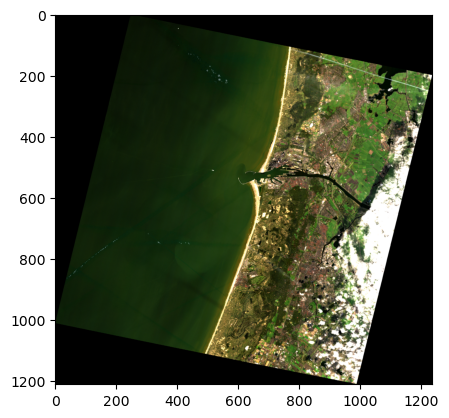

In [11]:
p = plt.imshow(np.swapaxes(np.swapaxes(TCI,0,2),0,1))

In [12]:
SWIRwl = meta.xpath('/level_X/product/image/merge/qlChannelsSWIR/*/text()')
SWIRwl = list(map(float,SWIRwl))
print(SWIRwl)

[2199.71, 1653.33, 1048.19]


In [13]:
SWIRda = da.sel(band=SWIRwl,method="nearest")
SWIRda = SWIRda * da.FWHMOfBand * da.GainOfBand
SWIR = SWIRda.values
SWIR[SWIR==da.attrs["_FillValue"]] = np.nan

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


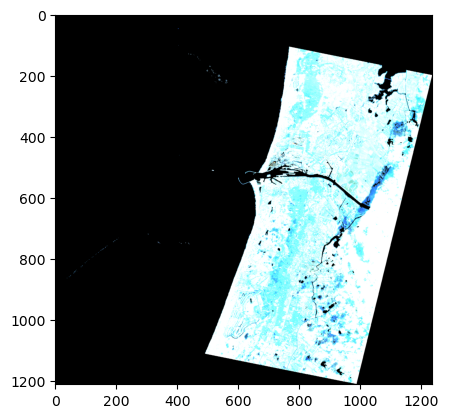

In [14]:
p = plt.imshow(np.swapaxes(np.swapaxes(SWIR,0,2),0,1))

In [15]:
DA = da.values.astype(float)
#DA[DA==da.attrs["_FillValue"]] = np.nan
DA = DA * da.FWHMOfBand.values[:,None,None] * da.GainOfBand.values[:,None,None]

In [16]:
DAz = np.swapaxes(np.swapaxes(DA,0,2),0,1)[200:1000,200:1000]
TCIz = np.swapaxes(np.swapaxes(TCI,0,2),0,1)[200:1000,200:1000]

In [18]:
DAz.shape, TCIz.shape

((800, 800, 224), (800, 800, 3))

# k-Means Clustering

In [19]:
import spectral

In [20]:
result = spectral.kmeans(DAz, 20, 30)

spectral:INFO: k-means iteration 1 - 265208 pixels reassigned.
spectral:INFO: k-means iteration 2 - 44729 pixels reassigned.
spectral:INFO: k-means iteration 3 - 18660 pixels reassigned.
spectral:INFO: k-means iteration 4 - 14591 pixels reassigned.
spectral:INFO: k-means iteration 5 - 12771 pixels reassigned.
spectral:INFO: k-means iteration 6 - 10933 pixels reassigned.
spectral:INFO: k-means iteration 7 - 9424 pixels reassigned.
spectral:INFO: k-means iteration 8 - 8591 pixels reassigned.
spectral:INFO: k-means iteration 9 - 8237 pixels reassigned.
spectral:INFO: k-means iteration 10 - 8240 pixels reassigned.
spectral:INFO: k-means iteration 11 - 8350 pixels reassigned.


KeyboardInterrupt: Returning clusters from previous iteration.


In [21]:
classes = result[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


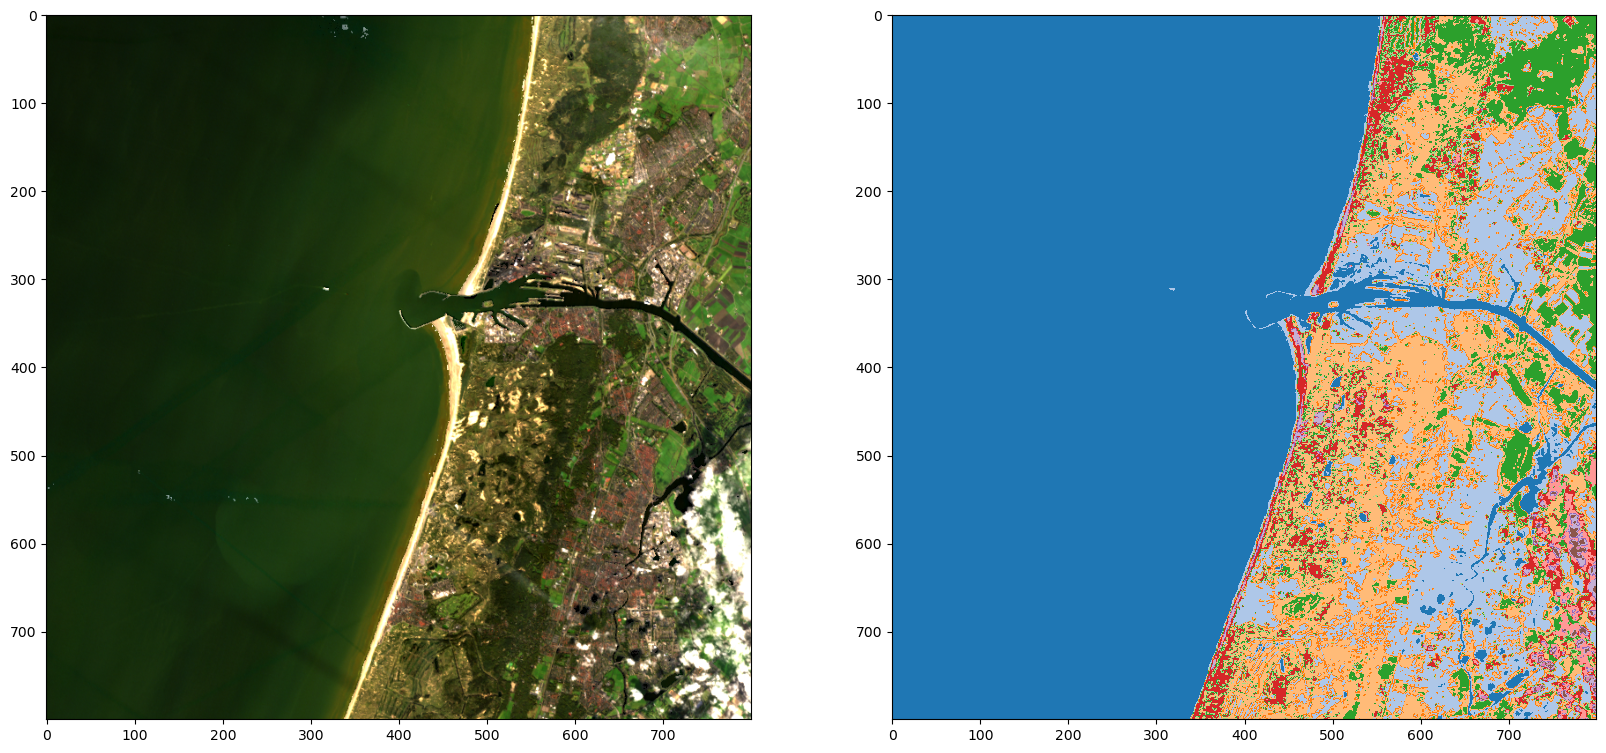

In [28]:
fig, axs = plt.subplots(1,2,figsize=(20,40))
axs[0].imshow(np.swapaxes(np.swapaxes(TCI,0,2),0,1)[200:1000,200:1000])
axs[1].imshow(classes,cmap="tab20",alpha=1)